In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [72]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bgspy.genome import Genome
from bgspy.utils import load_bed_annotation, read_bed3, ranges_to_masks
from bgspy.genome import process_annotation

In [58]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv")

In [59]:
hg38_autos = {c: k for c, k in g.seqlens.items() if c not in ('chrX', 'chrY', 'chrM')}

In [60]:
hg38_len = sum(v for c, v in hg38_autos.items())
hg38_len/1e9

2.875001522

## Annotation Tracks

We need basic statistics on the conserved annotation tracks — their composition etc.

In [71]:
utrs = read_bed3('../data/annotation/hg38.ensembl_utrs.bed.gz')
introns = read_bed3('../data/annotation/hg38.ensembl_introns.bed.gz')
cds = read_bed3('../data/annotation/hg38.ensembl_cds.bed.gz')

In [181]:
def combine_features(feature_ranges, priority, seqlens):
    features = {feat: ranges_to_masks(r, seqlens) for feat, r in feature_ranges.items()}
    assert set(priority) == set(features)
    masks = dict()
    for chrom in seqlens:
        merged = np.zeros(seqlens[chrom], dtype='int')
        for i, feature in enumerate(priority, start=1):
            idx = features[feature][chrom] & (merged == 0)
            merged[idx] = i
        masks[chrom] = merged
    return masks


def rle(inarray):
        """
        Run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values)
        
        Source: https://stackoverflow.com/a/32681075/147427 (thx SO)
        """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])

def masks_to_ranges(mask_dict, priority):
    ranges = defaultdict(list)
    for chrom in mask_dict:
        rls, starts, vals = rle(mask_dict[chrom])
        for rl, s, val in zip(rls, starts, vals):
            if val == 0:
                continue
            ranges[chrom].append((s, s + rl, priority[val-1]))
    return ranges


In [194]:
def test_combine_features():
    """
    
    """
    sl = {'chr1': 13}
    feature_ranges = {'introns': {'chr1':[(1, 3), (5, 8)]}, 'cds': {'chr1':[(2, 4), (8, 9)]}}
    #expected = {'chr1': array([0., 2., 1., 1., 0., 2., 2., 2., 1., 0., 0., 0., 0.])}
    priority = ('cds', 'introns')
    a = combine_features(feature_ranges, priority, sl)
    b = {'chr1': np.array([0., 2., 1., 1., 0., 2., 2., 2., 1., 0., 0., 0., 0.])}
    assert all(a['chr1'] == b['chr1'])
    c = {'chr1': [(1, 2, 'introns'),
                  (2, 4, 'cds'),
                  (5, 8, 'introns'),
                  (8, 9, 'cds')]}
    assert c['chr1'] == masks_to_ranges(a, priority)['chr1']

test_combine_features()

In [195]:
debug

> /tmp/ipykernel_78889/720844927.py(40)masks_to_ranges()
     37         for rl, s, val in zip(rls, starts, vals):
     38             if val == 0:
     39                 continue
---> 40             ranges[chrom].append((s, s + rl, priority[val-1]))
     41     return ranges



ipdb>  exit


In [182]:
masks_to_ranges(combine_features(feature_ranges, priority, sl), priority)

defaultdict(list,
            {'chr1': [(1, 2, 'introns'),
              (2, 4, 'cds'),
              (5, 8, 'introns'),
              (8, 9, 'cds')]})

In [165]:
mask = np.array([0., 2., 1., 1., 0., 2., 2., 2., 1., 0., 0., 0., 0.])

rle(mask)

(array([1, 1, 2, 1, 3, 1, 4]),
 array([0, 1, 2, 4, 5, 8, 9]),
 array([0., 2., 1., 0., 2., 1., 0.]))

In [160]:
def feature_encoding_to_ranges(x):
    

feature_encoding_to_ranges(mask)

[(1, 3), (2, 4), (3, 6), (5, 7), (6, 8), (7, 9)]

In [ ]:
tmp = np.where(np.diff(mask) > 0)[0].reshape((-1, 2)).tolist()

In [122]:
res['chr1'][res['chr1'] > 0]

array([2., 2., 2., ..., 2., 2., 2.])

In [125]:
masks_to_ranges(res, ('cds', 'utrs', 'introns'))

AssertionError: 

In [126]:
debug

> /tmp/ipykernel_78889/2783139028.py(19)masks_to_ranges()
     17         tmp = np.where(np.diff(mask) > 0)[0].reshape((-1, 2)).tolist()
     18         feats = mask[mask > 0]
---> 19         assert len(feats) == len(tmp)
     20         ranges[chrom] = [tuple(x + [priority[i]]) for x, i in enumerate(tmp, feats)]
     21 



ipdb>  len(feats)


110959788


ipdb>  len(tmp)


16829


ipdb>  exit


In [118]:
res['chr10'].size

133797422

In [95]:
res = combine_features(dict(utrs=utrs, introns=introns, cds=cds), ('cds', 'utrs', 'introns'), g.seqlens)

In [99]:
feature, counts = np.unique(res['chr1'], return_counts=True)

In [100]:
feature, counts / res['chr1'].size

(array([0., 1., 2., 3.]),
 array([0.55430036, 0.01449661, 0.02051146, 0.41069157]))

In [74]:
ranges_to_masks(utrs, g.seqlens)

{'chr1': array([False, False, False, ..., False, False, False]),
 'chr2': array([False, False, False, ..., False, False, False]),
 'chr3': array([False, False, False, ..., False, False, False]),
 'chr4': array([False, False, False, ..., False, False, False]),
 'chr5': array([False, False, False, ..., False, False, False]),
 'chr6': array([False, False, False, ..., False, False, False]),
 'chr7': array([False, False, False, ..., False, False, False]),
 'chr8': array([False, False, False, ..., False, False, False]),
 'chr9': array([False, False, False, ..., False, False, False]),
 'chr10': array([False, False, False, ..., False, False, False]),
 'chr11': array([False, False, False, ..., False, False, False]),
 'chr12': array([False, False, False, ..., False, False, False]),
 'chr13': array([False, False, False, ..., False, False, False]),
 'chr14': array([False, False, False, ..., False, False, False]),
 'chr15': array([False, False, False, ..., False, False, False]),
 'chr16': array([Fa

In [70]:
utrs['chr1']

[(65419, 65433),
 (65520, 65564),
 (70009, 71585),
 (923923, 924431),
 (923923, 924431),
 (925150, 925189),
 (925731, 925800),
 (925922, 925941),
 (925922, 925941),
 (944154, 944259),
 (944154, 944574),
 (944154, 944574),
 (944154, 944574),
 (944154, 944575),
 (944203, 944693),
 (959241, 959256),
 (960584, 960693),
 (963387, 963504),
 (963920, 964008),
 (964107, 964167),
 (964349, 964530),
 (965192, 965719),
 (966482, 966531),
 (966502, 966531),
 (966502, 966531),
 (974576, 974588),
 (974576, 975008),
 (974576, 975008),
 (974576, 975865),
 (975198, 976171),
 (975204, 976171),
 (975712, 975865),
 (976121, 976171),
 (981030, 981047),
 (981030, 981173),
 (981167, 981173),
 (982065, 982093),
 (982065, 982093),
 (982065, 982117),
 (998962, 999058),
 (998964, 999058),
 (998970, 999058),
 (999974, 1000097),
 (999974, 1000172),
 (999974, 999981),
 (1001138, 1001281),
 (1001145, 1001263),
 (1008194, 1008279),
 (1008194, 1008279),
 (1013497, 1013573),
 (1013984, 1014004),
 (1013984, 1014004),
 (

In [62]:
merged_annot = load_bed_annotation('../data/annotation/merged_utrs_cds_introns.bed.gz')

In [63]:
def annot_summary(annot, seqlens):
    annot, all_features = annot
    nfeats = defaultdict(Counter)
    total_bp = defaultdict(Counter)
    frac = defaultdict(Counter)
    lengths = defaultdict(lambda: defaultdict(list))
    for chrom, (ranges, features) in annot.items():
        for (start, end), feature in zip(ranges, features):
            nfeats[chrom][feature] += 1
            total_bp[chrom][feature] += end-start
            lengths[chrom][feature].append(end-start)
    for chrom in total_bp:
        for feature, val in total_bp[chrom].items():
            frac[chrom][feature] = val / seqlens[chrom]
    return nfeats, total_bp, frac, lengths

def annot_merged_summary(annot, genome_length):
    annot, all_features = annot
    nfeats = Counter()
    total_bp = Counter()
    frac = Counter()
    lengths = defaultdict(list)
    for chrom, (ranges, features) in annot.items():
        for (start, end), feature in zip(ranges, features):
            nfeats[feature] += 1
            total_bp[feature] += end-start
            lengths[feature].append(end-start)

    for feature, val in total_bp.items():
        frac[feature] = val / genome_length
    return nfeats, total_bp, frac, lengths



In [64]:
annot_merged_summary(merged_annot, hg38_len)

(Counter({'UTR': 35809, 'CDS': 81350, 'intron': 22499}),
 Counter({'UTR': 215810156, 'CDS': 893694321, 'intron': 158048326}),
 Counter({'UTR': 0.07506436234853583,
          'CDS': 0.31085003404739064,
          'intron': 0.05497330168022081}),
 defaultdict(list,
             {'UTR': [145,
               1576,
               508,
               539,
               15,
               109,
               527,
               49,
               1595,
               96,
               198,
               6938,
               3803,
               380,
               61,
               1136,
               849,
               1739,
               630,
               5291,
               11763,
               46,
               105,
               65,
               2819,
               88,
               20,
               25,
               41,
               1772,
               94,
               31,
               418,
               1172,
               827,
               175,
         

(array([4.568e+03, 1.091e+03, 5.890e+02, 3.380e+02, 2.620e+02, 2.000e+02,
        1.330e+02, 9.800e+01, 7.600e+01, 6.300e+01, 6.400e+01, 5.100e+01,
        3.000e+01, 2.600e+01, 2.500e+01, 2.500e+01, 2.100e+01, 1.700e+01,
        1.200e+01, 1.300e+01, 1.000e+01, 1.000e+01, 1.000e+01, 1.200e+01,
        4.000e+00, 7.000e+00, 4.000e+00, 4.000e+00, 9.000e+00, 3.000e+00,
        2.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

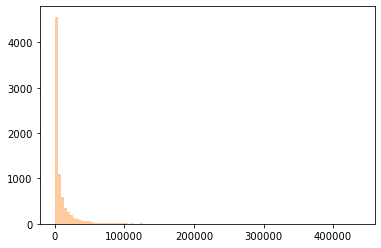

In [52]:
plt.hist(annot_summary(merged_annot, g.seqlens)[3]['chr1']['introns'], 100)
plt.hist(annot_summary(merged_annot, g.seqlens)[3]['chr1']['CDS'], 100, alpha=0.4)

## PhastCons Thresholding

In Murphy et al. they pay attention to thresholding their conserved tracks, so here's a little exploration into this with the phastCons dataset:

In [ ]:
d = pd.read_csv('../data/annotation/phastConsElements100way.txt.gz', sep='\t', names=('chr', 'start', 'end', 'lod', 'score'))
d = d.loc[d.chr.isin(hg38_autos)]
d['score'] = d['score'] / 1000
d['width'] = d['end'] - d['start']

In [ ]:
d['chr'].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'],
      dtype=object)

In [ ]:
score = d['score'].values

(array([2.512443e+06, 3.886167e+06, 1.561838e+06, 8.749850e+05,
        3.985250e+05, 1.341740e+05, 3.636900e+04, 9.232000e+03,
        1.727000e+03, 6.400000e+01]),
 array([0.186 , 0.2674, 0.3488, 0.4302, 0.5116, 0.593 , 0.6744, 0.7558,
        0.8372, 0.9186, 1.    ]),
 <BarContainer object of 10 artists>)

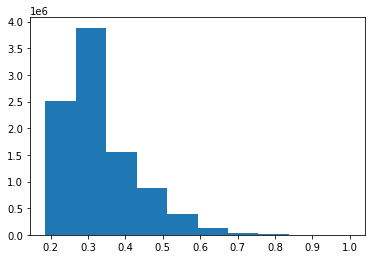

In [ ]:
plt.hist(score)

In [ ]:
q = np.quantile(score, 0.90)
q * 1000

471.0

In [ ]:
np.quantile(score, 0.95) * 1000

527.0

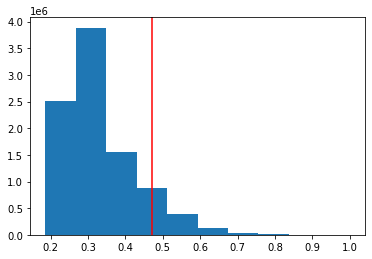

In [ ]:
plt.hist(score)
plt.axvline(q, c='r')

In [ ]:
q

0.471

In [71]:
d.loc[d.score > q].width.sum() / hg38_len, d.width.sum() / hg38_len

(0.01853522601369948, 0.050822503529791174)

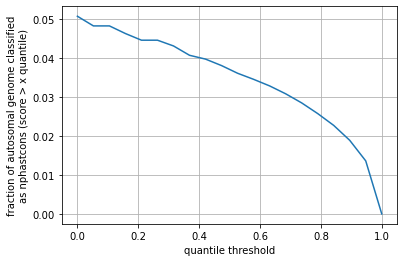

In [79]:
quants = np.linspace(0, 1, 20)

plt.plot(quants, [d.loc[d.score > np.quantile(d.score, q)].width.sum()/hg38_len for q in quants])
plt.ylabel('fraction of autosomal genome classified\nas nphastcons (score > x quantile)')
plt.xlabel('quantile threshold')
plt.grid()

In [81]:
np.quantile(score, (0, 0.5, 0.9, 0.95))*1000


array([186., 300., 471., 527.])